In [21]:
import random
import sys

import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from warnings import filterwarnings

In [22]:
sys.setrecursionlimit(10000)
filterwarnings('ignore')

In [23]:
class Regression(object):
    """
    Performs kNN regression
    """

    def __init__(self):
        self.k = 5
        self.metric = np.mean
        self.kdtree = None
        self.houses = None
        self.values = None

    def set_data(self, houses, values):
        """
        Sets houses and values data
        :param houses: pandas.DataFrame with houses parameters
        :param values: pandas.Series with houses values
        """
        self.houses = houses
        self.values = values
        self.kdtree = KDTree(self.houses)

    def regress(self, query_point):
        """
        Calculates predicted value for house with particular parameters
        :param query_point: pandas.Series with house parameters
        :return: house value
        """
        _, indexes = self.kdtree.query(query_point, self.k)
        value = self.metric(self.values.iloc[indexes])
        if np.isnan(value):
            raise Exception('Unexpected result')
        else:
            return value

In [24]:
class RegressionTest(object):
    """
    Take in King County housing data, calculate and plot the kNN regression error rate.
    """

    def __init__(self):
        self.houses = None
        self.values = None

    def load_csv_file(self, csv_file, limit=None):
        """
        Loads CSV file with houses data
        :param csv_file: CSV file name
        :param limit: number of rows of file to read
        """
        houses = pd.read_csv(csv_file, nrows=limit)
        self.values = houses['AppraisedValue']
        houses = houses.drop('AppraisedValue', 1)
        houses = (houses - houses.mean()) / (houses.max() - houses.min())
        self.houses = houses
        self.houses = self.houses[['lat', 'long', 'SqFtLot']]

    def plot_error_rates(self):
        """
        Plots MAE vs #folds
        """
        folds_range = range(2, 11)
        errors_df = pd.DataFrame({'max': 0, 'min': 0}, index=folds_range)
        for folds in folds_range:
            errors = self.tests(folds)
            errors_df['max'][folds] = max(errors)
            errors_df['min'][folds] = min(errors)
        errors_df.plot(title='Mean Absolute Error of KNN over different folds_range')
        plt.xlabel('#folds_range')
        plt.ylabel('MAE')
        plt.show()

    def tests(self, folds):
        """
        Calculates mean absolute errors for series of tests
        :param folds: how many times split the data
        :return: list of error values
        """
        holdout = 1 / float(folds)
        errors = []
        for _ in range(folds):
            values_regress, values_actual = self.test_regression(holdout)
            errors.append(mean_absolute_error(values_actual, values_regress))

        return errors

    def test_regression(self, holdout):
        """
        Calculates regression for out-of-sample data
        :param holdout: part of the data for testing [0,1]
        :return: tuple(y_regression, values_actual)
        """
        test_rows = random.sample(self.houses.index.tolist(),
                      int(round(len(self.houses) * holdout)))
        train_rows = set(range(len(self.houses))) - set(test_rows)
        df_test = self.houses.ix[test_rows]
        df_train = self.houses.drop(test_rows)

        train_values = self.values.ix[train_rows]
        regression = Regression()
        regression.set_data(houses=df_train, values=train_values)

        values_regr = []
        values_actual = []

        for idx, row in df_test.iterrows():
            values_regr.append(regression.regress(row))
            values_actual.append(self.values[idx])

        return values_regr, values_actual

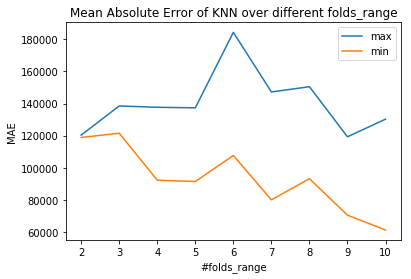

In [25]:
regression_test = RegressionTest()
regression_test.load_csv_file('king_county_data_geocoded.csv', 100)
regression_test.plot_error_rates()